In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import tree
import graphviz
from sklearn.preprocessing import LabelEncoder

In [2]:
# Load the dataframe
df = pd.read_csv('DOHMH_New_York_City_Restaurant_Inspection_Results.csv', delimiter=',')
#df.head(1)

## Describe the Data

In [3]:
original_len = len(df)
print('The original dataset is made of %d entries.' %(original_len))

The original dataset is made of 399918 entries.


In [4]:
df['INSPECTION DATE'] = pd.to_datetime(df['INSPECTION DATE'])
df = df[df['INSPECTION DATE'] > '2009-12-31']
df['MONTH']=pd.DatetimeIndex(df['INSPECTION DATE']).month

print('%d points had invalid dates.' %(original_len-len(df)))

1135 points had invalid dates.


Add the month and season of the inspection.

In [5]:
file_in = 'Violations_explanation.csv'
viol_dict = {}
with open(file_in, 'r') as f_in:
    f_in.readline() # Skip the header
    for line in f_in.readlines():
        line = line.strip('\n')
        line = line.split(';')
        viol_dict[line[0]] = line[-1]
df['VIOLATION TYPE'] = df['VIOLATION CODE'].map(viol_dict)

Pick the most common cuisines. Set the threshold to the percentage one wants.

In [6]:
cuisine_counts = {}
major_cuisines = []
threshold = 0.03 # Threshold to discriminate the presence of restaurants.

for i in df['CUISINE DESCRIPTION'].unique():
    cuisine_counts[i] = float(len(df[df['CUISINE DESCRIPTION']==i]))

major_cuisines = [i for i in cuisine_counts.keys() if cuisine_counts[i]/sum(cuisine_counts.values()) > threshold]

In [7]:
df = df[df['CUISINE DESCRIPTION'].isin(major_cuisines)]
print('The dataframe now is made of %d points' %(len(df)))

The dataframe now is made of 247178 points


Group the violations into categories

In [8]:
file_in = 'Violations_explanation.csv'
viol_dict = {}
with open(file_in, 'r') as f_in:
    f_in.readline() # Skip the header
    for line in f_in.readlines():
        line = line.strip('\n')
        line = line.split(';')
        viol_dict[line[0]] = line[-1]
df['VIOLATION TYPE'] = df['VIOLATION CODE'].map(viol_dict)

## Look at criticality of violations

There are 136550 critical flags and 107060 non critical flags.


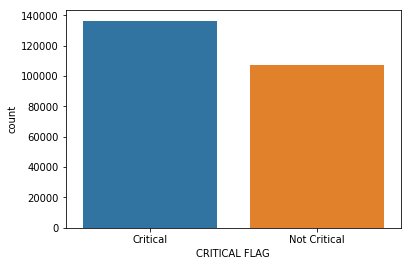

In [9]:
flags=df[df['CRITICAL FLAG'].isin(['Critical', 'Not Critical'])]
ax = sns.countplot(data=flags, x='CRITICAL FLAG')
print('There are %d critical flags and %d non critical flags.' %(sum(flags['CRITICAL FLAG']=='Critical'), sum(flags['CRITICAL FLAG']=='Not Critical')))

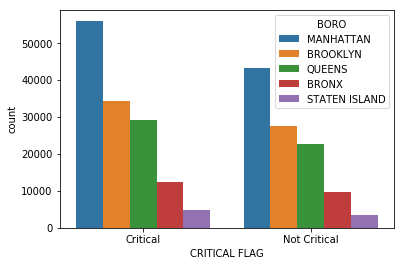

In [11]:
flags.head()
ax = sns.countplot(data=flags, x='CRITICAL FLAG', hue='BORO', hue_order=flags['BORO'].value_counts().index)

MANHATTAN has 56104 Critical Violations and 43417 Non Critical Violations.


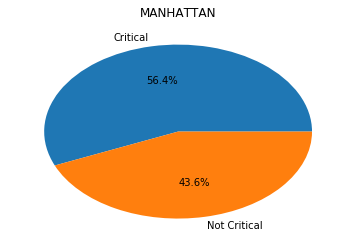

QUEENS has 29150 Critical Violations and 22754 Non Critical Violations.


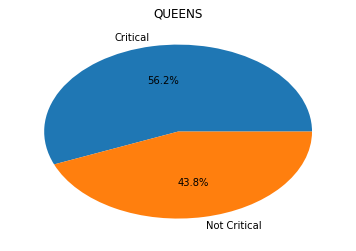

STATEN ISLAND has 4727 Critical Violations and 3444 Non Critical Violations.


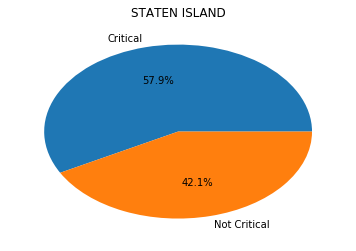

BROOKLYN has 34245 Critical Violations and 27647 Non Critical Violations.


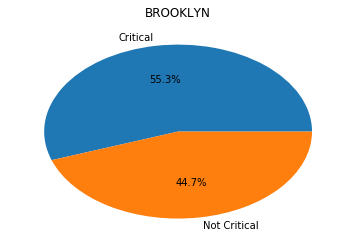

BRONX has 12324 Critical Violations and 9798 Non Critical Violations.


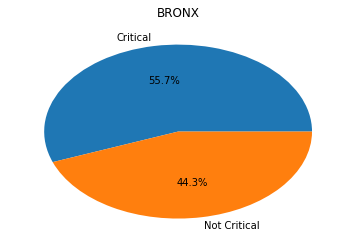

In [26]:
labels = ['Critical', 'Not Critical']

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%".format(pct, absolute)

for i in flags['BORO'].unique():
    criticalities = []
    flags_bor = flags[flags['BORO'] == i]
    criticalities = [len(flags_bor[flags_bor['CRITICAL FLAG']==l]) for l in flags['CRITICAL FLAG'].unique()]
    print('%s has %d Critical Violations and %d Non Critical Violations.' %(i, criticalities[0], criticalities[1]))
    plt.title(i)
    plt.pie(x=criticalities, labels=labels, autopct=lambda pct: func(pct, criticalities))
    plt.show()

Plotted the grades divided by boros

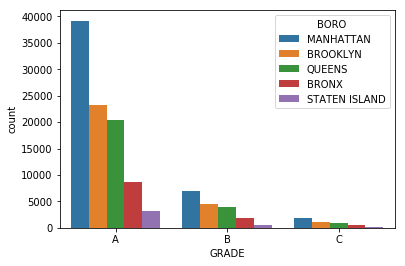

In [27]:
grades = df[df['GRADE'].isin(['A','B', 'C'])]
#grades['GRADE'].value_counts()
ax = sns.countplot(x='GRADE', hue='BORO', data=grades, order=grades['GRADE'].value_counts().index, hue_order=grades['BORO'].value_counts().index)

Plotted the average scores by boro

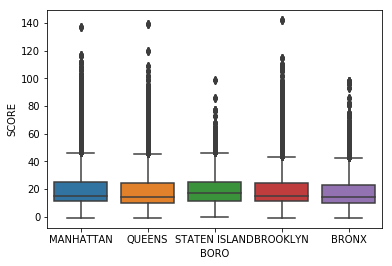

In [28]:
df['SCORE'].dropna()
boros = df[df['BORO'] != 'Missing']
ax = sns.boxplot(x='BORO', y='SCORE', data=boros)


Look at the violations by season

Change the date fromat
Some dates are recorded wrongly, the inspections start on Jan 1, 2010.
All dates with a date earlier than Jan 1, 2010 have been dropped since there is no date that could be used to replace it.

In [29]:
season_dict = {}
for month in range(1,13):
    if month > 2 and month < 6:
        season_dict[month] = 'Spring'
    elif month > 2 and month < 9:
        season_dict[month] = 'Summer'
    elif month > 2 and month < 12:
        season_dict[month] = 'Fall'
    else:
        season_dict[month] = 'Winter'

df['SEASON'] = df['MONTH'].map(season_dict)

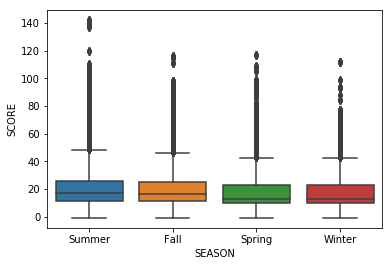

In [30]:
ax = sns.boxplot(x='SEASON', y='SCORE', data=df )

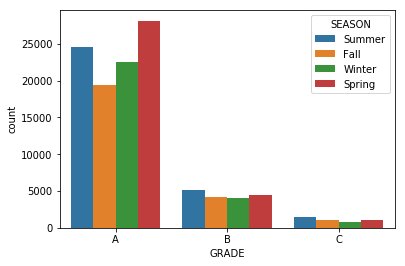

In [31]:
grades_by_seas = df[df['GRADE'].isin(['A','B', 'C'])]
ax = sns.countplot(x='GRADE', hue='SEASON', data=grades_by_seas, order=grades_by_seas['GRADE'].value_counts().index)

Most common violations by boro

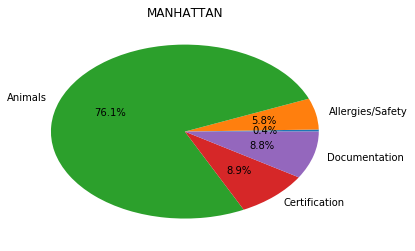

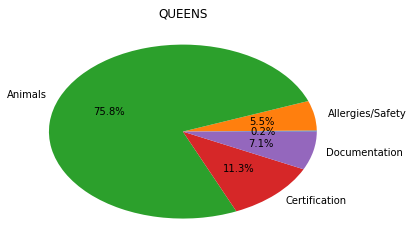

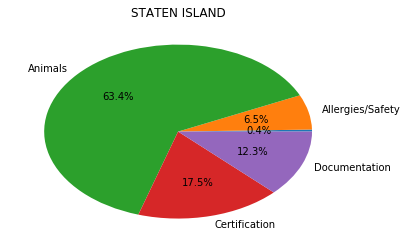

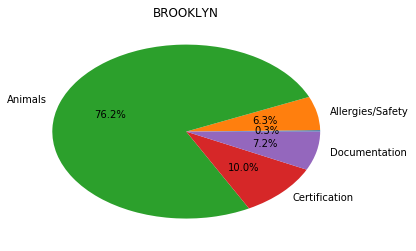

In [32]:
def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%".format(pct, absolute)

boros_list = df['BORO'].unique()
boros_list = np.delete(boros_list, -1)

for boro in boros_list:
    violations = df[df['BORO'] == boro].groupby(by='VIOLATION TYPE', sort=True)['BORO'].count().head(5)
    violations_pct = violations.values/violations.sum()
    ax = plt.pie(violations, labels=violations.keys(), autopct=lambda pct: func(pct, violations))
    plt.title(boro)
    plt.show()